In [1]:
import gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings

# DeprecationWarning 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 하이퍼파라미터 설정
lr_mu = 0.0005 # 정책 네트워크의 학습률
lr_q = 0.001 # 가치 네트워크의 학습률
gamma = 0.99 # 할인율(미래 보상에 대한 현재 가치)
batch_size = 32 # 배치 크기
buffer_limit = 50000 # 리플레이 버퍼의 최대 크기
tau = 0.005 # 타겟 네트워크 소프트 업데이트 비율

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)  # 버퍼를 deque로 초기화하여 최대 buffer_limit까지 저장 가능

    def put(self, transition):
        self.buffer.append(transition)  # 새로운 경험을 버퍼에 추가
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)  # 버퍼에서 무작위로 n개의 샘플을 추출
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []  # 각 요소를 저장할 리스트 초기화

        for transition in mini_batch:
            s, a, r, s_prime, done = transition  # 샘플링된 각 경험을 분리
            s_lst.append(s)  # 상태 추가
            a_lst.append(a)  # 행동 추가
            r_lst.append(r)  # 보상 추가
            s_prime_lst.append(s_prime)  # 다음 상태 추가
            done_mask = 0.0 if done else 1.0  # done 여부에 따라 done mask 설정
            done_mask_lst.append(done_mask)  # done mask 추가
        
        # 리스트를 numpy array로 변환
        s_lst = np.array(s_lst, dtype=np.float32)  # 상태 리스트를 numpy array로 변환
        a_lst = np.array(a_lst, dtype=np.float32).reshape(-1, 1)  # 행동 리스트를 numpy array로 변환하고 reshape
        r_lst = np.array(r_lst, dtype=np.float32).reshape(-1, 1)  # 보상 리스트를 numpy array로 변환하고 reshape
        s_prime_lst = np.array(s_prime_lst, dtype=np.float32)  # 다음 상태 리스트를 numpy array로 변환
        done_mask_lst = np.array(done_mask_lst, dtype=np.float32).reshape(-1, 1)  # done mask 리스트를 numpy array로 변환하고 reshape

        # numpy array를 텐서로 변환하여 반환
        return torch.tensor(s_lst), torch.tensor(a_lst), torch.tensor(r_lst), \
               torch.tensor(s_prime_lst), torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)  # 버퍼의 현재 크기를 반환

# 정책 네트워크 정의
class MuNet(nn.Module):
    def __init__(self):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(3, 128) # 첫 번째 은닉층
        self.fc2 = nn.Linear(128, 64) # 두 번째 은닉층
        self.fc_mu = nn.Linear(64, 1) # 출력층

    def forward(self, x):
        x = F.relu(self.fc1(x)) # 첫 번째 은닉층 활성화 함수 적용
        x = F.relu(self.fc2(x)) # 두 번째 은닉층 활성화 함수 적용
        mu = torch.tanh(self.fc_mu(x)) * 2 # 출력층에 tanh 함수 적용 후 [-2,2] 범위로 스케일링
        return mu

# 가치 네트워크 정의
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64) # 상태에 대한 첫 번째 은닉층
        self.fc_a = nn.Linear(1, 64) # 행동에 대한 첫 번째 은닉층
        self.fc_q = nn.Linear(128, 32) # 상태와 행동을 합친 후의 은닉층
        self.fc_out = nn.Linear(32, 1) # 출력층

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x)) # 상태에 대한 은닉층 활성화 함수 적용
        h2 = F.relu(self.fc_a(a)) # 행동에 대한 은닉층 활성화 함수 적용
        cat = torch.cat([h1, h2], dim=1) # 상태와 행동을 결합
        q = F.relu(self.fc_q(cat)) # 결합된 상태-행동에 대한 은닉층 활성화 함수 적용
        q = self.fc_out(q) # Q-값 출력
        return q

# Ornstein-Uhlenbeck 노이즈 클래스 정의
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1 # 노이즈 파라미터 설정
        self.mu = mu # 평균값
        self.x_prev = np.zeros_like(self.mu) # 이전 값 초기화

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape) # 노이즈 계산
        self.x_prev = x # 이전 값 업데이트
        return x

# 훈련 함수 정의
def train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer):
    s, a, r, s_prime, done_mask = memory.sample(batch_size) # 리플레이 버퍼에서 배치 샘플링
    
    target = r + gamma * q_target(s_prime, mu_target(s_prime)) * done_mask # 타겟 Q-값 계산
    q_loss = F.smooth_l1_loss(q(s, a), target.detach()) # 가치 네트워크의 손실 계산
    q_optimizer.zero_grad() # 가치 네트워크의 기울기 초기화
    q_loss.backward() # 손실에 대한 기울기 계산
    q_optimizer.step() # 가치 네트워크 업데이트
    
    mu_loss = -q(s, mu(s)).mean() # 정책 네트워크의 손실 계산
    mu_optimizer.zero_grad() # 정책 네트워크의 기울기 초기화
    mu_loss.backward() # 손실에 대한 기울기 계산
    mu_optimizer.step() # 정책 네트워크 업데이트

# 타겟 네트워크 소프트 업데이트 함수 정의
def soft_update(net, net_target):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau) # 타겟 네트워크 업데이트

In [2]:
# 환경 설정
env = gym.make('Pendulum-v1', max_episode_steps=200, autoreset=True) # 기본모드로 진행 (human으로 하면 처음부터 지속적으로 렌더링됨)
# env = gym.make('Pendulum-v1', max_episode_steps=200, autoreset=True, render_mode='human')  # 'human' 모드로 렌더링
memory = ReplayBuffer() # 리플레이 버퍼 생성

q, q_target = QNet(), QNet() # 가치 네트워크 및 타겟 네트워크 생성
q_target.load_state_dict(q.state_dict()) # 타겟 네트워크 초기화
mu, mu_target = MuNet(), MuNet() # 정책 네트워크 및 타겟 네트워크 생성
mu_target.load_state_dict(mu.state_dict()) # 타겟 네트워크 초기화

score = 0.0 # 점수 초기화
print_interval = 20 # 출력 간격 설정

mu_optimizer = optim.Adam(mu.parameters(), lr=lr_mu) # 정책 네트워크의 최적화 알고리즘 설정
q_optimizer = optim.Adam(q.parameters(), lr=lr_q) # 가치 네트워크의 최적화 알고리즘 설정
ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1)) # Ornstein-Uhlenbeck 노이즈 생성


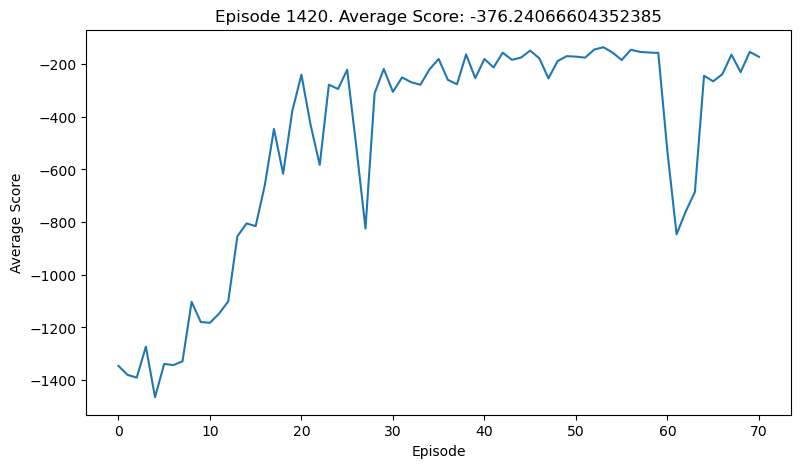

# of episode :20, avg score : -1345.8
# of episode :40, avg score : -1380.2
# of episode :60, avg score : -1390.5
# of episode :80, avg score : -1272.9
# of episode :100, avg score : -1464.9
# of episode :120, avg score : -1338.5
# of episode :140, avg score : -1342.9
# of episode :160, avg score : -1328.6
# of episode :180, avg score : -1102.8
# of episode :200, avg score : -1179.4
# of episode :220, avg score : -1182.4
# of episode :240, avg score : -1147.5
# of episode :260, avg score : -1101.2
# of episode :280, avg score : -854.2
# of episode :300, avg score : -805.2
# of episode :320, avg score : -815.2
# of episode :340, avg score : -659.4
# of episode :360, avg score : -446.3
# of episode :380, avg score : -616.4
# of episode :400, avg score : -378.5
# of episode :420, avg score : -240.3
# of episode :440, avg score : -430.6
# of episode :460, avg score : -583.1
# of episode :480, avg score : -278.5
# of episode :500, avg score : -294.6
# of episode :520, avg score : -221.7
# o

KeyboardInterrupt: 

In [3]:
# 점수를 기록할 리스트 초기화
scores = []
avg_scores = []
output_log = []  # 출력 로그를 저장할 리스트

def plot_progress(frame_idx, scores, avg_scores, output_log):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.title('Episode %s. Average Score: %s' % (frame_idx, np.mean(avg_scores[-10:])))
    plt.plot(avg_scores)
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.show()
    
    # 누적된 출력 로그를 출력
    for log in output_log:
        print(log)

for n_epi in range(10000):  # 10000 에피소드 동안 훈련
    s, _ = env.reset()  # 환경 리셋
    done = False  # done 변수 초기화

    count = 0
    episode_score = 0.0  # 에피소드 점수 초기화
    while count < 200 and not done:  # 최대 200 스텝 동안 에피소드 진행
        a = mu(torch.from_numpy(s).float())  # 정책 네트워크를 사용해 행동 선택
        a = a.item() + ou_noise()[0]  # 행동에 노이즈 추가
        s_prime, r, done, truncated, info = env.step([a])  # 환경에서 행동 수행
        memory.put((s, a, r / 100.0, s_prime, done))  # 리플레이 버퍼에 경험 저장
        score += r  # 점수 업데이트
        episode_score += r  # 에피소드 점수 업데이트
        s = s_prime  # 다음 상태로 이동
        count += 1

    scores.append(episode_score)  # 에피소드 점수 기록

    if memory.size() > 2000:  # 리플레이 버퍼에 충분한 경험이 쌓이면
        for _ in range(10):  # 10번 학습
            train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer)  # 네트워크 훈련
            soft_update(mu, mu_target)  # 정책 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target)  # 가치 타겟 네트워크 소프트 업데이트

    if n_epi % print_interval == 0 and n_epi != 0:  # 일정 에피소드마다
        avg_score = sum(scores[-print_interval:]) / print_interval  # 최근 print_interval 에피소드의 평균 점수 계산
        avg_scores.append(avg_score)  # 평균 점수 기록
        log_message = "# of episode :{}, avg score : {:.1f}".format(n_epi, avg_score)
        output_log.append(log_message)  # 로그 메시지를 리스트에 추가
        print(log_message)  # 로그 메시지를 출력
        score = 0.0  # 점수 초기화
        
        plot_progress(n_epi, scores, avg_scores, output_log)  # 그래프 업데이트

        if avg_score > -200:  # 평균 점수가 -200보다 큰 경우
            env_render = gym.make('Pendulum-v1', max_episode_steps=200, render_mode='human')  # 'human' 모드로 환경 생성
            s_render, _ = env_render.reset()  # 렌더링 환경 리셋
            done_render = False
            count_render = 0
            while count_render < 200 and not done_render:  # 최대 200 스텝 동안 에피소드 진행
                a_render = mu(torch.from_numpy(s_render).float())  # 정책 네트워크를 사용해 행동 선택
                a_render = a_render.item()
                s_render_prime, r_render, done_render, truncated_render, info_render = env_render.step([a_render])  # 환경에서 행동 수행
                s_render = s_render_prime  # 다음 상태로 이동
                count_render += 1
            env_render.close()  # 렌더링 환경 종료

env.close()  # 환경 종료

# Pendulum 찾아보기
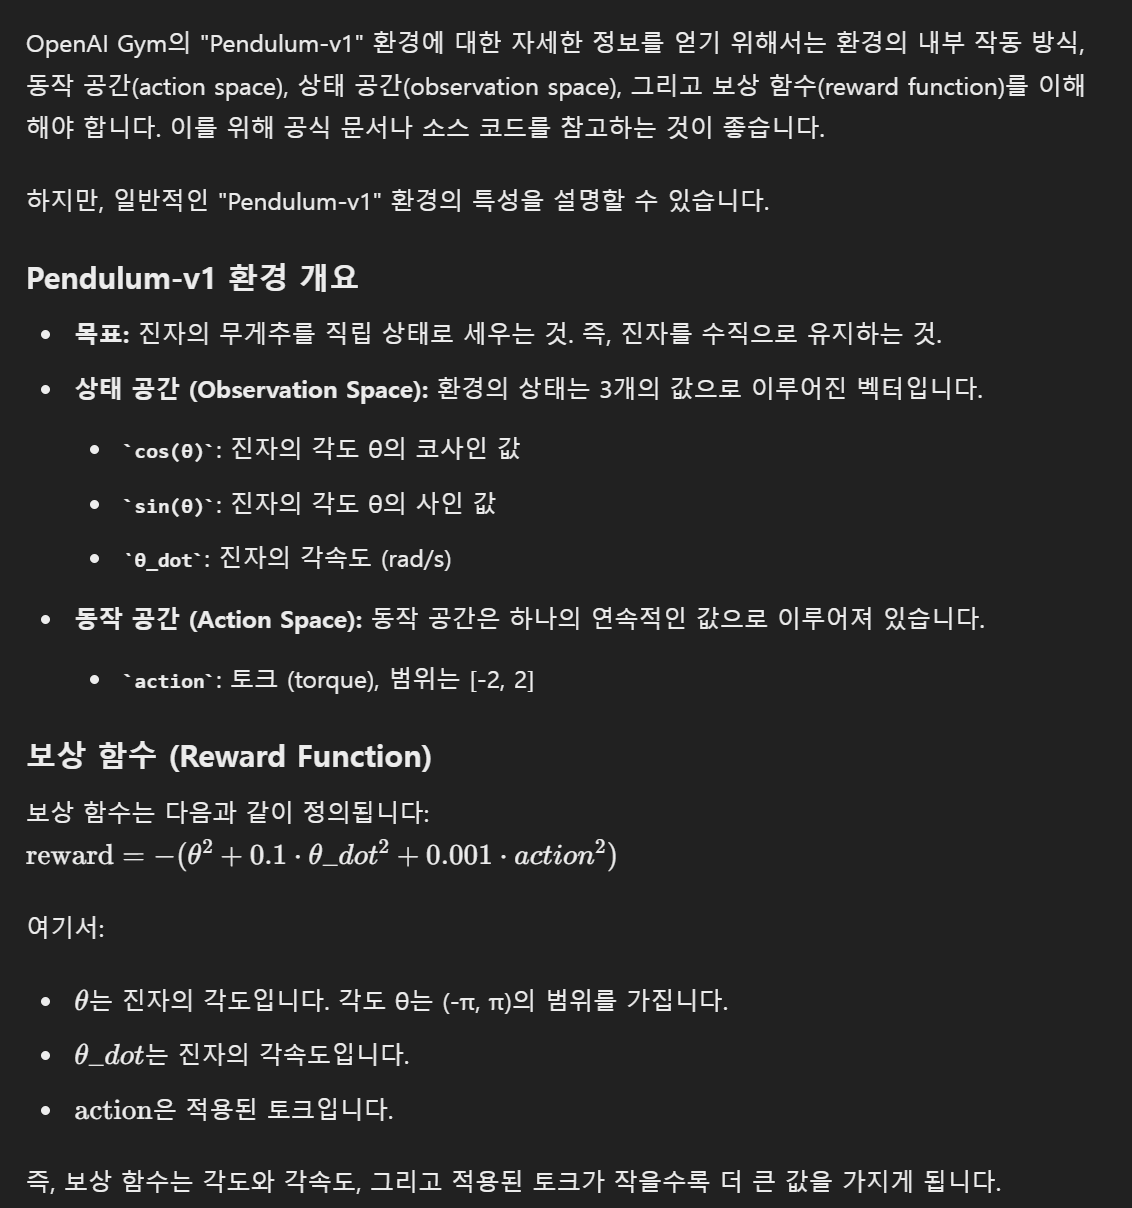

## Reward design
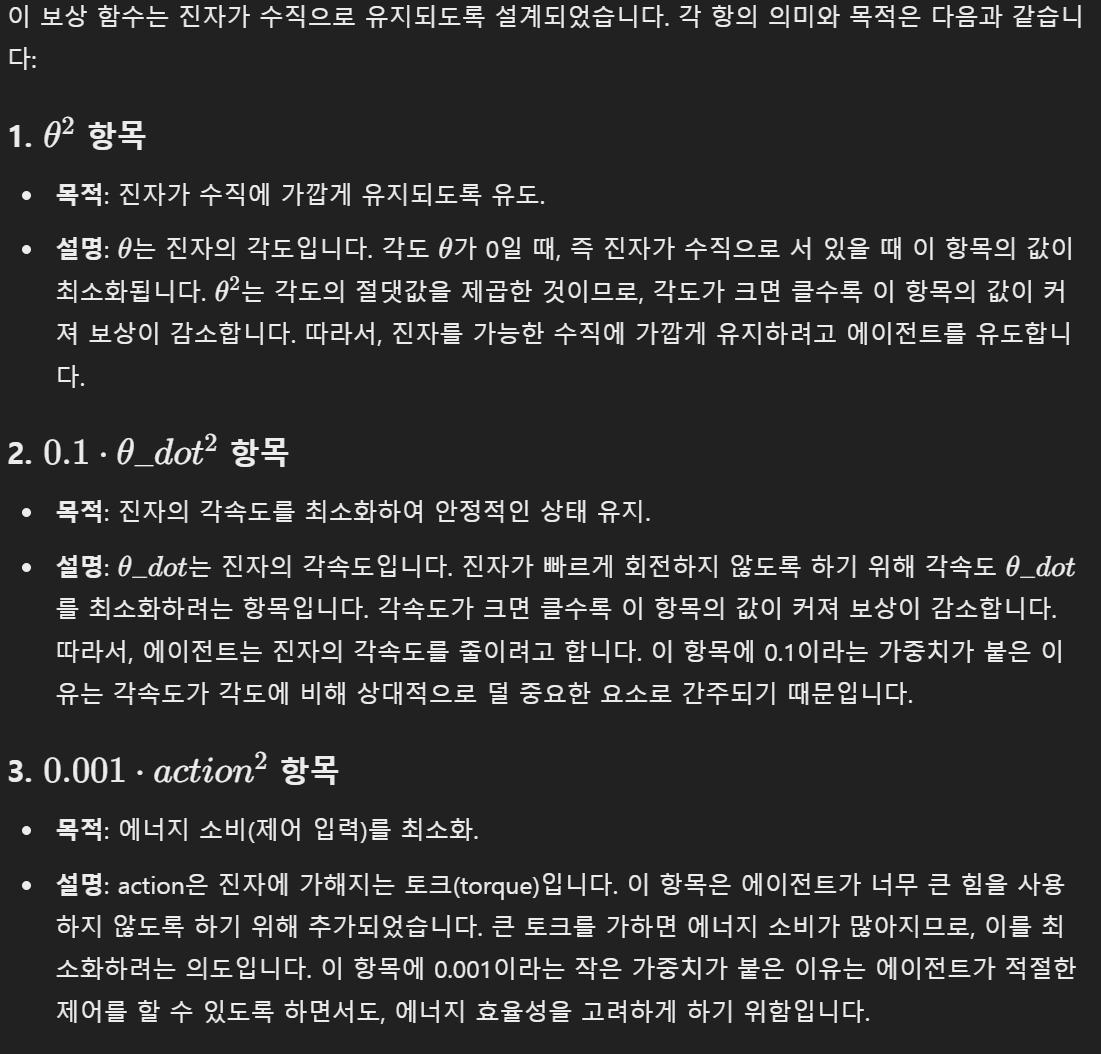
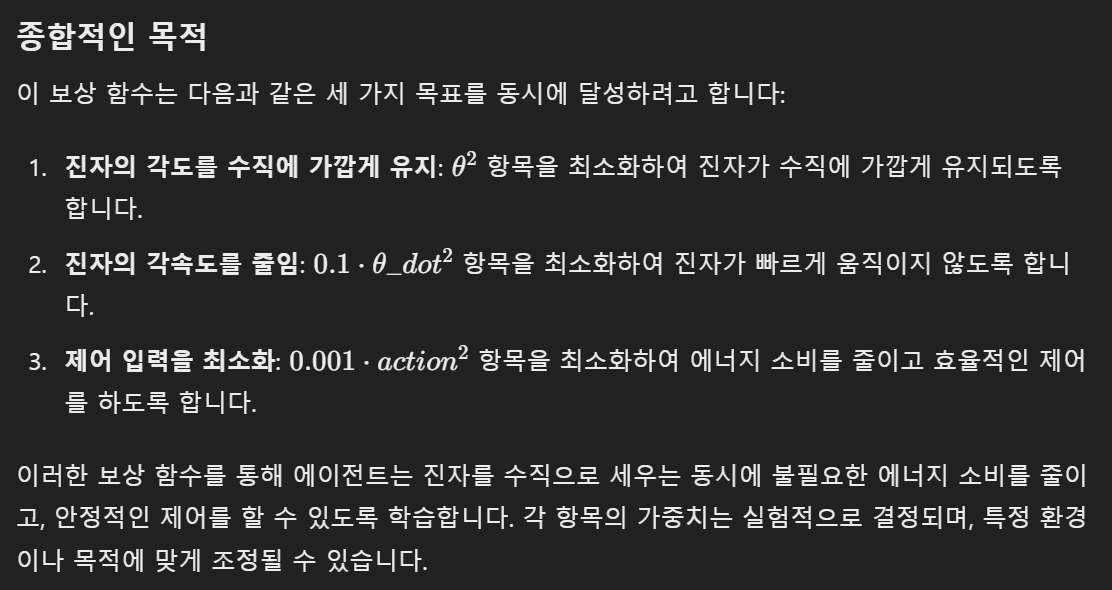

In [4]:
import gym

# 환경 생성
env = gym.make('Pendulum-v1')

# 동작 공간 확인
print("Action space:", env.action_space) # 하한, 상한, 차원, 데이터타입 출력 
print("Action space bounds:", env.action_space.low, env.action_space.high)

# 상태 공간 확인
print("Observation space:", env.observation_space)
print("Observation space bounds:", env.observation_space.low, env.observation_space.high)

# 초기 상태 확인
observation, _ = env.reset()
print("Initial observation:", observation)

# 샘플 동작을 적용하여 보상 함수 확인
action = env.action_space.sample()
observation, reward, done, truncated, info = env.step(action)
print("Action:", action)
print("Observation:", observation)
print("Reward:", reward)

env.close()


Action space: Box(-2.0, 2.0, (1,), float32)
Action space bounds: [-2.] [2.]
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation space bounds: [-1. -1. -8.] [1. 1. 8.]
Initial observation: [-0.39178792 -0.92005557 -0.01185979]
Action: [0.43205693]
Observation: [-0.42089224 -0.90711063 -0.6370929 ]
Reward: -3.8943914089286547


# 이것저것 Try

## OU Noise

In [ ]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        print(f"Generated noise: {x}")  # 생성된 노이즈 출력
        return x

In [ ]:
ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1))
noise_values = []  # 노이즈 값을 기록할 리스트

for n_epi in range(10000):
    s, _ = env.reset()
    done = False

    count = 0
    while count < 200 and not done:
        a = mu(torch.from_numpy(s).float())
        noise = ou_noise()[0]
        a = a.item() + noise
        s_prime, r, done, truncated, info = env.step([a])
        memory.put((s, a, r / 100.0, s_prime, done))
        score += r
        s = s_prime
        count += 1

        noise_values.append(noise)  # 노이즈 값을 기록

    if memory.size() > 2000:
        for i in range(10):
            train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer)
            soft_update(mu, mu_target)
            soft_update(q, q_target)

    if n_epi % print_interval == 0 and n_epi != 0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score / print_interval))
        score = 0.0

env.close()

# 기록된 노이즈 값을 시각화
plt.plot(noise_values)
plt.title('Ornstein-Uhlenbeck Noise')
plt.xlabel('Step')
plt.ylabel('Noise Value')
plt.show()